https://math.stackexchange.com/questions/1792539/how-do-we-convert-annual-growth-rate-to-daily-growth-rate
https://stackoverflow.com/questions/13556703/array-elementwise-operations
https://matplotlib.org/stable/tutorials/colors/colormaps.html
https://stackoverflow.com/questions/17559408/confidence-and-prediction-intervals-with-statsmodels

In [27]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
tx_fee = pd.read_csv('../resources/ETHTransactionFee.csv')
tx_fee.columns = ['date', 'timestamp','tx_fee']
tx_fee = tx_fee.assign(tx_fee = [float(tx)/1e18 for tx in tx_fee['tx_fee'].values])
date_split = [t.rstrip().split('/') for t in tx_fee['date'].values]
date_times = [datetime.date(int(t[2]), int(t[0]), int(t[1])) for t in date_split]
tx_fee = tx_fee.assign(date_time = date_times)

In [29]:
tx_fee.loc[100]

date          11/7/2015
timestamp    1446854400
tx_fee          32.0799
date_time    2015-11-07
Name: 100, dtype: object

In [30]:
INITIAL_SYS_SUPPLY = 614730694.63 # June 28th, 2021
MAX_COINS = 888000000
DAYS_IN_YEAR = 365
ANNUAL_INFLATION = 0.05
DAILY_PERCENTAGE_GRWTH = (1+ANNUAL_INFLATION)**(1/DAYS_IN_YEAR)
LAST_DATE = '2021-06-28 00:00:00'
START_DATE = '2015-11-07 00:00:00'

In [31]:
def supplyNYears(A,t):
    return A*(1.05)**t

def supplyNDays(A,t):
    daysInYr = 366 if isLeapYear(getDate(t, strt_date = LAST_DATE).year) else 365
    return A*(1.05)**(t/365)

In [32]:
def isLeapYear(yr):
    return bool((yr-2000) % 4 == 0) 

def getDate(t, strt_date = START_DATE):
    return datetime.datetime.strptime(strt_date, "%Y-%m-%d %H:%M:%S") + datetime.timedelta(days=t) 

In [33]:
N = 365*8 + 1

supply = [INITIAL_SYS_SUPPLY]
for t in range(1,N): supply.append(supply[-1]*DAILY_PERCENTAGE_GRWTH)
supply = np.array(supply)
dates = np.array([getDate(t) for t in range(0,N)])

df = pd.DataFrame({'dates':dates.flatten(), 'inflate':supply.flatten()})
df['inflate'].values[-1]

908237211.2454726

In [34]:
INITIAL_SYS_SUPPLY*(DAILY_PERCENTAGE_GRWTH-1)

82177.57861674666

In [35]:
supplyNDays(INITIAL_SYS_SUPPLY,3*365)

711627620.3710538

In [36]:
supplyNYears(INITIAL_SYS_SUPPLY,3)

711627620.3710538

In [37]:
def f(t_x,n_coins_y):
    n_supply = supplyNDays(INITIAL_SYS_SUPPLY,t_x)
    val = 1
    if(n_coins_y < 0.1*n_supply):
        val = 4
    elif (n_coins_y >= 0.1*n_supply and n_coins_y < 0.25*n_supply):
        val = 3
    elif (n_coins_y >= 0.25*n_supply and n_coins_y < n_supply):
        val = 2        
    else:
        val = 0
    return val  

In [38]:
Xt = np.linspace(0, 3000, 1000)
Xdate = list(map(getDate, Xt))
Y = np.linspace(0, 1e9, 1000)
t, n_coins = np.meshgrid(Xt, Y)

In [39]:
def applier(a, b, op):
    return list(map(lambda ro: list(map(op, ro[0], ro[1])), zip(a,b)))
Z = applier(t, n_coins, f)

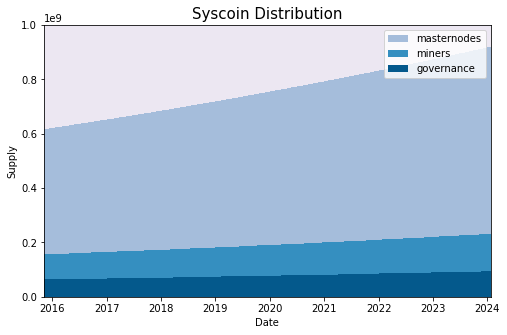

In [40]:
fig = plt.figure(figsize=(8, 5))

cs = plt.contourf(Xdate,Y,Z, cmap='PuBu', levels=[0,1,2,3,4])

proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cs.collections]

plt.ylabel("Supply")
plt.xlabel("Date")
plt.title("Syscoin Distribution", fontsize=15)

plt.legend(proxy[1:], ["masternodes", "miners", "governance"])
plt.show()

In [41]:
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import summary_table
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import numpy as np
import random

y = np.log(tx_fee['tx_fee'].values[100:])
x = np.log(np.array(range(1,len(y)+1)))

X = sm.add_constant(x)
regr = sm.OLS(y, X)
fit = regr.fit()
y_hat = fit.fittedvalues
prstd, y_hat_lwr, y_hat_upr = wls_prediction_std(fit)

st, data, ss2 = summary_table(fit, alpha=0.05)

x_new = np.log(np.array(range(2061,2061+N)))
X_p = sm.add_constant(x_new)
pred = fit.get_prediction(X_p)

y_pred = pred.predicted_mean
y_pred_lwr = y_pred - 1.96*prstd[0]
y_pred_upr = y_pred + 1.96*prstd[0]

In [42]:
mc_sim = [np.random.normal(y_pred[k], prstd[0],100) for k in range(0,len(y_pred))]
mc_sim_med = [np.median(mc_sim[k]) for k in range(0,len(y_pred))]
mc_sim_lwr = [np.quantile(mc_sim[k],0.05) for k in range(0,len(y_pred))]
mc_sim_upr = [np.quantile(mc_sim[k],0.95) for k in range(0,len(y_pred))]

In [43]:
sim = mc_sim[0]
for k in range(1,len(y_pred)):
    sim = np.vstack((sim, mc_sim[k]))

In [44]:
dates = [getDate(t) for t in range(0,2062)]
dates_pred = [getDate(t) for t in range(2061,2061+N)]

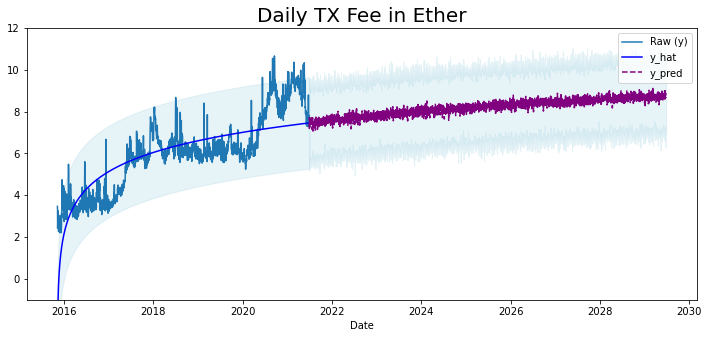

In [53]:
x = np.array(range(1,len(y)+1))
x_pred = np.array(range(2061,2061+N))

fig = plt.figure(figsize=(12,5))
ax = fig.gca()
plt.plot(dates, y, label="Raw (y)")
plt.plot(dates, y_hat, color='blue', label="y_hat")
plt.fill_between(dates, y_hat_lwr, y_hat_upr, alpha=0.3, color='lightblue')

#plot_gp_dist(ax, sim.transpose(), np.array(dates_pred), palette="BuPu")
#plt.plot(dates_pred, y_pred, color='blue', linestyle='dashed', label="y_pred")
plt.plot(dates_pred, mc_sim_med, color='purple', linestyle='dashed', label="y_pred")
#plt.fill_between(dates_pred, y_pred_lwr, y_pred_upr, alpha=0.3, color='lightblue')
plt.fill_between(dates_pred, mc_sim_lwr, mc_sim_upr, alpha=0.3, color='lightblue')
plt.title("Daily TX Fee in Ether", fontsize=20)
plt.xlabel("Date")
plt.ylim(-1,12)
fig.savefig('../img/eth_daily_tx_fee.png')
plt.legend();

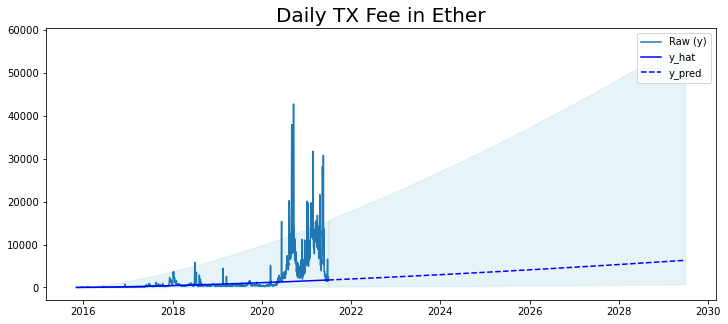

In [46]:
x = np.array(range(1,len(y)+1))
x_pred = np.array(range(2061,2061+N))

fig = plt.figure(figsize=(12,5))
plt.plot(dates, np.exp(y), label="Raw (y)")
plt.plot(dates, np.exp(y_hat), color='blue', label="y_hat")
plt.fill_between(dates, np.exp(y_hat_lwr), np.exp(y_hat_upr), alpha=0.3, color='lightblue')

plt.plot(dates_pred, np.exp(y_pred), color='blue', linestyle='dashed', label="y_pred")
plt.fill_between(dates_pred, np.exp(y_pred_lwr), np.exp(y_pred_upr), alpha=0.3, color='lightblue')
plt.title("Daily TX Fee in Ether", fontsize=20)
fig.savefig('../img/eth_daily_tx_fee2.png')
plt.legend();

Text(0.5, 24.0, 'Date')

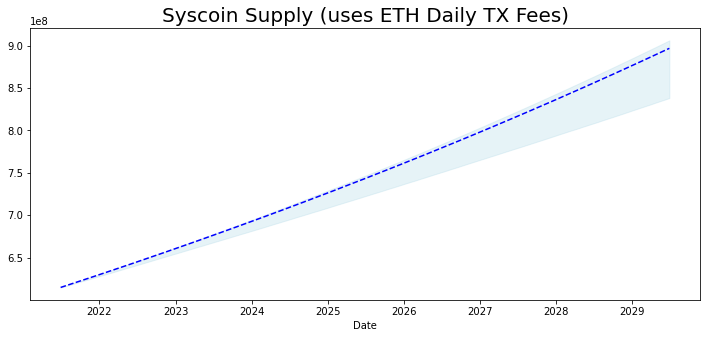

In [55]:
new_supply = np.array([supplyNDays(INITIAL_SYS_SUPPLY,t) for t in range(0,N)])
coin_supply_mu = new_supply - np.cumsum(np.exp(y_pred)) 
coin_supply_lwr = new_supply - np.cumsum(np.exp(mc_sim_lwr)) 
coin_supply_upr = new_supply - np.cumsum(np.exp(mc_sim_upr)) 

fig = plt.figure(figsize=(12,5))
plt.plot(dates_pred, coin_supply_mu, color='blue', linestyle='dashed', label="y_pred")
plt.fill_between(dates_pred, coin_supply_lwr, coin_supply_upr, alpha=0.3, color='lightblue')
plt.title("Syscoin Supply (uses ETH Daily TX Fees)", fontsize=20)
fig.savefig('../img/syscoin_daily_supply.png')
plt.xlabel("Date")

In [48]:
df_pred = pd.DataFrame({'dates':np.array(dates_pred).flatten(), 
                        'yr':pd.to_datetime(np.array(dates_pred)).year, 
                        'mo':pd.to_datetime(np.array(dates_pred)).month,
                        'da':pd.to_datetime(np.array(dates_pred)).day,
                        'new_supply':new_supply.flatten(),
                        'coin_supply_mu':coin_supply_mu.flatten(),
                        'coin_supply_lwr':coin_supply_lwr.flatten(),
                        'coin_supply_upr':coin_supply_upr.flatten()
                       })

In [49]:
supplyNYears(INITIAL_SYS_SUPPLY,3)

711627620.3710538

In [50]:
supplyNDays(INITIAL_SYS_SUPPLY,3*365)

711627620.3710538

In [51]:
cond = (df_pred['yr'] == 2024) & (df_pred['mo'] == 6) & (df_pred['da'] == 29)
df_pred['new_supply'].loc[cond].values[0]

711722751.1904999

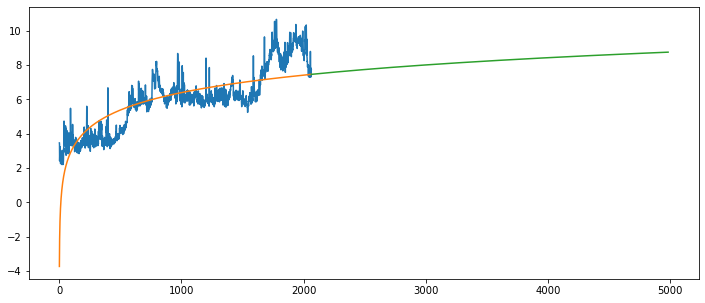

In [52]:
from scipy.optimize import curve_fit

x = np.array(range(1,len(y)+1))
y = np.log(tx_fee['tx_fee'].values[100:])

def func(x, p1, p2):
    return p1 + p2*np.log(x) 


popt, pcov = curve_fit(func, x, y)

p1 = popt[0]
p2 = popt[1]

# plot curve
y_hat = func(x,p1,p2)

x_new = np.array(range(x[-1],x[-1]+N))
y_pred = func(x_new,p1,p2)

plt.figure(figsize=(12,5))
plt.plot(x, y, label="Raw data")
plt.plot(x, y_hat, label="Raw data")
plt.plot(x_new, y_pred, label="Raw data")
